To run this script we recommend running example2 first to create all the
necessary outpouts from GLMsingle that are going to be reused here.

This script shows how to find single-trial beta weights in the output of
the GLMsingle. We will show how to average them to create one response
to each condition rather then a response to each trial. This will produce
one beta weight for each condition. Additionaly we will show how to 
calculate a t-statistic for each condition and a contrast between two 
example conditions in the fLoc experiment (number vs. face) using single 
trial betas.


### Import function libraries

In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import warnings
warnings.filterwarnings('ignore')

from glmsingle.glmsingle import GLM_single

### Set paths and load the example2 design matrices

In [113]:
# get path to the directory to which GLMsingle was installed
datadir = join(homedir,'examples','data')
homedir = split(os.getcwd())[0]
datafn = join(datadir,'nsdflocexampledataset.mat')
X = sio.loadmat(datafn)

nruns = len(X['data'][0])
design = []
data  = []
# iterate through each run of data
for r in range(nruns):
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    data.append(X['data'][0,r])


xyz = data[0].shape[:3]
xyzt = data[0].shape


In [27]:
# This NSD fLOC scan session has 6 repetitions of each condition per run.
# In the code below, we are attempting to locate the indices in the beta
# weight GLMsingle outputs modelmd(x,y,z,trials) that correspond to
# repeated conditions.

designALL = np.concatenate(design,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)



In [51]:
# We will now find indices for each condition. First lets find all unique
# condition in the corder list

repindices = []

for p in range(designALL.shape[1]): # loop over every condition
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    if len(temp) >= 3:
        repindices.append(temp)

repindices = np.vstack(np.array(repindices)).T      

"There are %i repetition of %i unique conditions" % (np.shape(repindices)[0], np.shape(repindices)[1])

'There are 24 repetition of 10 unique conditions'

In [52]:
# Knowing the indicies of each condition we can now load an example output
# of GLMsingle and create 1 beta weight for each condition. In the example
# 1 there are 10 unique conditions.

### Load GLMsingle results from example2 

In [53]:
results_glmsingle = dict()
outputdir_glmsingle = join(homedir,'examples','example2outputs','GLMsingle')
results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

In [90]:
betas = results_glmsingle['typed']['betasmd']
condition_list = np.unique(corder)
betas_average = np.zeros([np.shape(betas)[0],np.shape(betas)[1],np.shape(betas)[2],len(condition_list)])

for k in condition_list:
    betas_average[:,:,:,k] = np.mean(betas[:,:,:,np.where(corder==0)[0]],3)



In [95]:
print('GLMsingle output had %i betas before averaging \n' % np.shape(betas)[3])
print('GLMsingle output has %i betas after averaging \n' % np.shape(betas_average)[3])

GLMsingle output had 240 betas before averaging 

GLMsingle output has 10 betas after averaging 



In [97]:
# Calculate t-statistic for each condition
# We calculate t-stat as the mean over the standard deviation across all
# repetitions of the same condition. 

t_stat = np.zeros([np.shape(betas)[0],np.shape(betas)[1],np.shape(betas)[2],len(condition_list)])
for k in condition_list:
    t_stat[:,:,:,k] = np.mean(betas[:,:,:,np.where(corder==0)[0]],3) / np.std(betas[:,:,:,np.where(corder==0)[0]],3)


In [202]:
# Calculate a contrast between condition 2 (number) and condition 5 (adult face)
cond1 = betas[:,:,:,np.where(corder==1)[0]]
cond2 = betas[:,:,:,np.where(corder==4)[0]]
np.shape(cond2)
ttest = scipy.stats.ttest_ind(cond1,cond2,3)
tval = ttest[0];
pval = ttest[1]


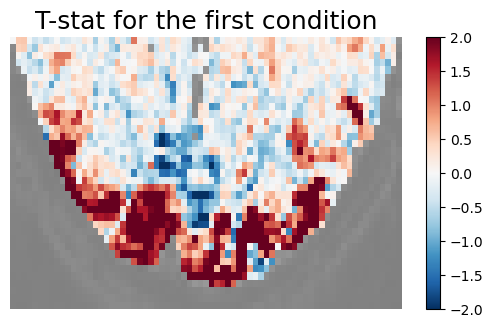

In [206]:
meanvol = np.squeeze(np.mean(data[0].reshape(xyzt),3))
brainmask = meanvol > 275
plt.figure(figsize=(55/1.5,18/1.5))

s = 16 # pick a slice
plot_data = t_stat;
plot_data[~brainmask] = np.nan # remove values outside the brain for visualization purposes
plot_data = plot_data[15:,5:-5,s,0]
plt.subplot(3,5,c)
plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),
            aspect='auto',cmap='gray',clim=(0,1), alpha=0.5)
plt.imshow(plot_data,aspect='auto',cmap='RdBu_r',clim=(-2,2))
plt.title('T-stat for the first condition',fontsize=18)
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.show()
# The t-statistic (t_stat) shows high values in the visual cortex

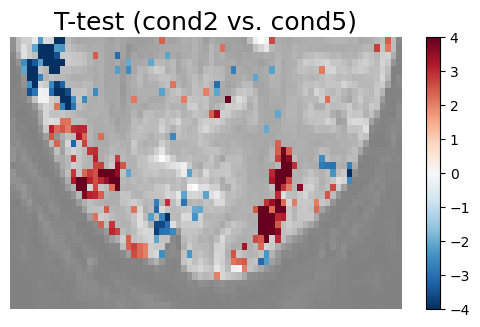

In [208]:
plt.figure(figsize=(55/1.5,18/1.5))

s = 21 # pick a slice
plot_data = tval;
plot_data[~brainmask] = np.nan # remove values outside the brain for visualization purposes
plot_data[~(pval<0.05)] = np.nan # remove values below p<0.05


plot_data = plot_data[15:,5:-5,s]
plt.subplot(3,5,1)
plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),
            aspect='auto',cmap='gray',clim=(0,1), alpha=0.5)
plt.imshow(plot_data,aspect='auto',cmap='RdBu_r',clim=(-4,4))
plt.title('T-test (cond2 vs. cond5)',fontsize=18)
plt.colorbar()
plt.box(False)
plt.axis(False)
plt.show()
# t-test between two conditions shows positive voxels in more ventral and
# lateral portions of the brain.